In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='nisha123',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:\SQL_Project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host='localhost',
                          username='root',
                          password='nisha123',
                          database='ecommerce')

In [2]:
cur=db.cursor()


# Count the number of orders palced in 2017

In [6]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data=cur.fetchall()
data[0][0]

90202

# List all unique cities where customers are located

In [27]:
query="""select distinct customer_city from customers """
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["customer_city"])
df.head()

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Find the total sales per category

In [12]:
query="""select upper(products.product_category), round(sum(payments.payment_value),2) sales
from products
join order_items on products.product_id=order_items.product_id
join payments on payments.order_id=order_items.order_id
group by products.product_category"""
cur.execute(query)
data=cur.fetchall()
data

df=pd.DataFrame(data,columns=["Category","Sales"])
df


,Category,Sales
0,PERFUMERY,1013477.32
1,FURNITURE DECORATION,2860352.78
2,TELEPHONY,973764.10
3,BED TABLE BATH,3425107.34
4,AUTOMOTIVE,1704588.66
...,...,...
69,CDS MUSIC DVDS,2398.86
70,LA CUISINE,5827.06
71,FASHION CHILDREN'S CLOTHING,1571.34
72,PC GAMER,4348.86


# Calculate the percentage of orders that were paid in installments

In [15]:
query="""select (sum(case when payment_installments>=1 then 1
else 0 end))/count(*)*100 from payments"""
cur.execute(query)
data=cur.fetchall()
data

[(Decimal('99.9981'),)]

# Count the number of customers from each state

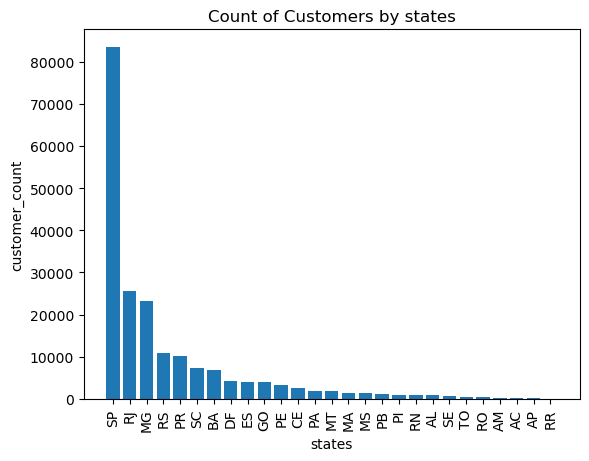

In [44]:
query="""select customer_state,count(customer_id) 
from customers group by customer_state"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by="customer_count",ascending=False)
plt.bar(df.state,df.customer_count)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by states")
plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month in 2018

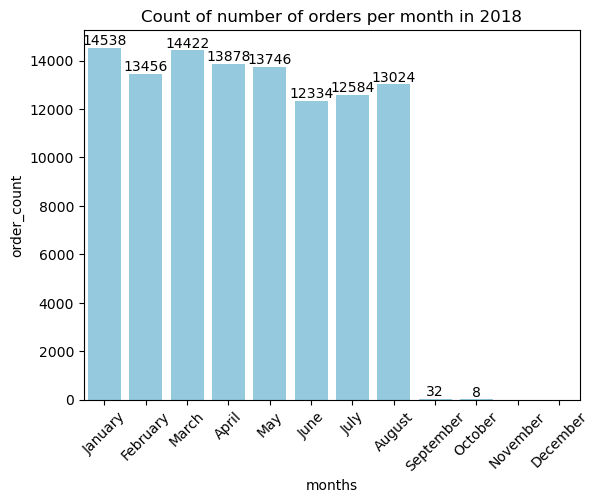

In [52]:
query="""select monthname(order_purchase_timestamp) months,count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018
group by months"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","order_count"])
o=["January","February","March","April","May","June","July","August","September","October","November","December"]
ax=sns.barplot(x=df.months,y=df.order_count,data=df,order=o,color="skyblue")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of number of orders per month in 2018")
plt.show()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
db=mysql.connector.connect(host='localhost',
                          username='root',
                          password='nisha123',
                          database='ecommerce')
cur=db.cursor()

# Find the average number of products per order,grouped by customer city

In [10]:
query="""with count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by average_orders desc"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer city","average products/order"])
df

,customer city,average products/order
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
...,...,...
4105,tuiuti,2.00
4106,tibau do sul,2.00
4107,sao mamede,2.00
4108,sambaiba,2.00


# Calculate the percentage of total revenue contributed by each product category

In [8]:
query="""select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category order by sales_percentage desc"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","percentage distribution"])
df

,Category,percentage distribution
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
...,...,...
69,PC GAMER,0.03
70,HOUSE COMFORT 2,0.02
71,CDS MUSIC DVDS,0.01
72,FASHION CHILDREN'S CLOTHING,0.01


# Identify the correlation between product price and the number of times a product has been purchased

In [12]:
import numpy as np
query="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","order_count","price"])

arr1=df["order_count"]
arr2=df["price"]
np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# Calculate the total revenue generated by the each seller and rank them by revenue

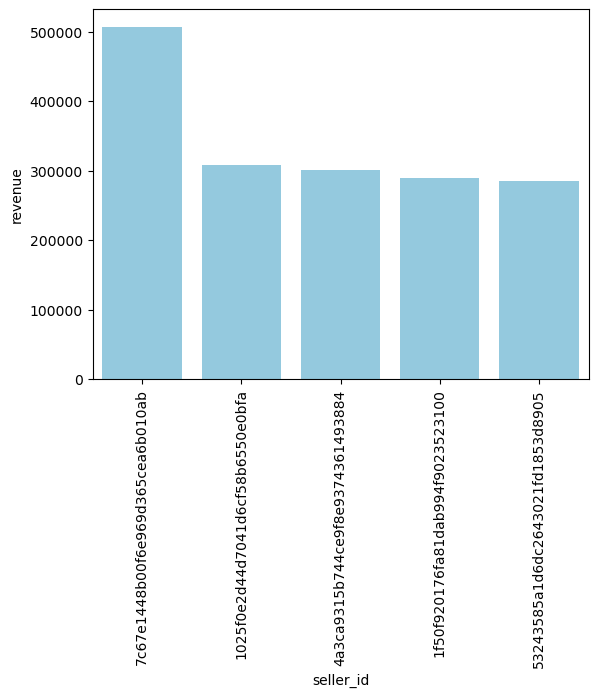

In [19]:
 query="""select *,dense_rank() over(order by revenue desc) as rn
 from(select order_items.seller_id,sum(payments.payment_value)
 revenue from order_items join payments
 on order_items.order_id=payments.order_id
 group by order_items.seller_id) as a"""
    
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df=df.head()
sns.barplot(x="seller_id",y="revenue",data=df,color="skyblue")
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history

In [23]:
query="""select customer_id,order_purchase_timestamp,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id) as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df


,0,1,2
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.370001


# Calculate the cumulative sales per month for each year

In [10]:
query="""select years,months,payment,sum(payment)
over(order by years,months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments 
on orders.order_id=payments.order_id
group by years,months order by years,months) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


# Calculate the year-over-year growth rate of total sales

In [15]:
query="""with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments 
on orders.order_id=payments.order_id
group by years order by years)
select years,((payment-lag(payment,1) over(order by years))/
lag(payment,1) over(order by years))*100 from a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","sales"])
df

,years,sales
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers,defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [20]:
query="""with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),

b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id=a.customer_id
and
orders.order_purchase_timestamp>first_order
and orders.order_purchase_timestamp<
date_add(first_order,interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id=b.customer_id"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df

,0
0,None


# Identify the top 3 customers who spent the most money in each year

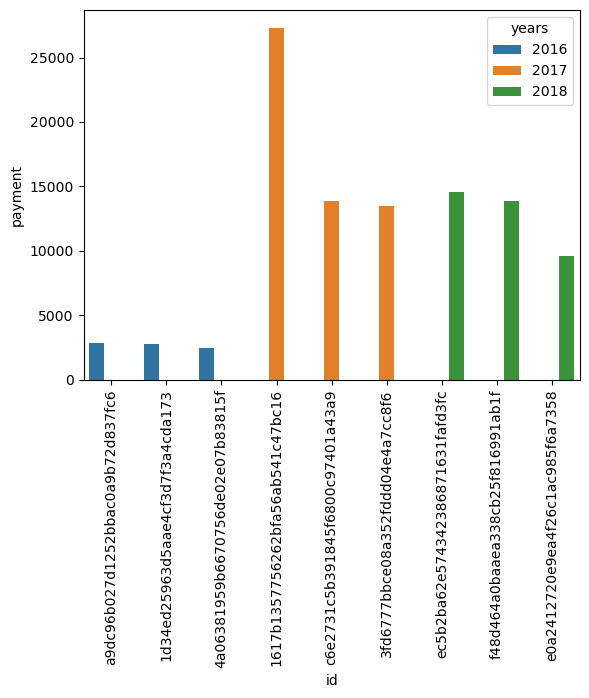

In [9]:
query = """
select years, customer_id, payment, d_rank
from (
    select year(orders.order_purchase_timestamp) years,
    orders.customer_id,
    sum(payments.payment_value) payment,
    dense_rank() over(partition by year(orders.order_purchase_timestamp)
    order by sum(payments.payment_value) desc) d_rank
    from orders
    join payments on payments.order_id = orders.order_id
    group by year(orders.order_purchase_timestamp), orders.customer_id
) as a
where d_rank <= 3
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years", "id", "payment", "rank"])


df['years'] = df['years'].astype(str)


sns.barplot(x="id", y="payment", data=df, hue="years")
plt.xticks(rotation=90)
plt.show()